<a href="https://www.kaggle.com/code/rubanzasilva/s5e7-fastai-gradient-boosting?scriptVersionId=250564139" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Personality Type Binary Classification

Our goal for this competition is to predict whether a person is an Introvert or Extrovert, given their social behavior and personality traits.

## Data & Library Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_datasert.csv
/kaggle/input/extrovert-vs-introvert-behavior-data/personality_dataset.csv


In [2]:
%%time
%pip install catboost
%pip install optuna
#%pip install optuna_distributed
#%pip install openfe
%pip install seaborn
%pip install xgboost
%pip install lightgbm
%pip install fastkaggle
#%pip install h2o
%pip install -Uqq fastbook
#%pip install polars
%pip install -q -U autogluon.tabular
%pip install autogluon
%pip install --upgrade pip
%pip install tqdm
#%pip install wandb
#%pip install sweetviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.1/124.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm

#import fastbook
#fastbook.setup_book()
#from fastbook import *
from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from tqdm import tqdm
from ipywidgets import interact

from fastai.imports import *
np.set_printoptions(linewidth=130)


from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier,StackingClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score,train_test_split,GridSearchCV


from pathlib import Path
import os

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from catboost import CatBoostClassifier,Pool, metrics, cv


import warnings


#from openfe import OpenFE, transform
#from autogluon.tabular import TabularDataset, TabularPredictor

#import h2o
#from h2o.automl import H2OAutoML

import gc

import optuna
from optuna.samplers import TPESampler

import pickle
from joblib import dump, load
#import sweetviz as sv
#from IPython.display import FileLink

#import h2o
#from h2o.automl import H2OAutoML

In [4]:
#torch.manual_seed(42)

In [5]:
path = Path('/kaggle/input/playground-series-s5e7/')
path

Path('/kaggle/input/playground-series-s5e7')

In [6]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv')
#original_df = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

In [7]:
#train_df.shape,original_df.shape

In [8]:
#train_df = pd.concat([train_df, original_df], ignore_index=True)

## Exploratory Data Analysis

In [9]:
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


## Data Pre-processing with fast.ai

The `RandomSplitter` function below separates the training set into a training and validation set based on the value of the argument `valid_pct`.

In [10]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [11]:
#I decided to put concat the original df and the train df after doing the split so that validation can be done on the competition dataset only.
#train_df = pd.concat([train_df, original_df], ignore_index=True)
#train_df = pd.concat(objs=[train_df, original_df])

Below, we are going to prepare our data for machine learning.

First, we define the categorical and continuous variables. I use the fastai `cont_cat_split` function to separate my dataset variables into categorical and continuous variables based on the cardinality of my column values.

`cont_cat_split` takes an argument,`max_card` whose default value is 20. If the number of unique values is above 20 (the default `max_card` value) for a particular column, that column is considered continuous, and vice versa.

Define a `TabularPandas` object. Here we define the continuous and categorical columns, the dataset splitting strategy, preprocessing steps to apply to our datasets, the dependent variable, which is what we are predicting, and the type of problem we are optimizing for, such as binary classification in this case.

I then create and define a `dataloaders` object, which prepares the data for input into our neural network. Here, we also define our batch size.

In [12]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='Personality')
#splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
#to = TabularPandas(train_df, procs=[Categorify,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Personality',
                   y_block=CategoryBlock(),
                   splits=splits)
dls = to.dataloaders(bs=64)
#dls = to.dataloaders(bs=1024)
test_dl = dls.test_dl(test_df)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)
/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

Finally, I extract the training and validation sets plus their values.

In [13]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

### Define Model Parameters

In [14]:
xgb_params = {'seed':42}
lgbm_params = {'seed':42}
cat_params = {'random_seed':42}
rf_params = {'random_state':42}

#### Cross Validation Function

In [15]:
def cross_val_predict(model_class, model_params=None, n_splits=5, random_state=42):
    if model_params is None:
        model_params = {}
    """
    Perform cross-validation using the fixed dataset and return predictions and scores.
    
    Parameters:
    - model_class: the model class (e.g., xgb.XGBClassifier)
    - model_params: dictionary of model parameters
    - n_splits: number of CV folds
    - random_state: random seed for reproducibility
    
    Returns:
    - oof_predictions: out-of-fold predictions on training set
    - submission_predictions: predictions on test_dl.xs
    - mean_score: mean accuracy score across folds
    - fold_scores: list of scores for each fold
    """
    
    # Initialize stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Initialize arrays to store results
    oof_predictions = np.zeros(len(X_train))  # Array for OOF predictions
    submission_predictions = np.zeros(len(test_dl.xs))  # Array for test predictions
    fold_scores = []
    
    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
        # Split data for current fold
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        # Initialize and train model on current fold
        model_fold = model_class(**model_params)
        model_fold.fit(X_fold_train, y_fold_train)
        
        # Get predictions
        y_pred_fold = model_fold.predict(X_fold_val)
        
        # Store OOF predictions
        oof_predictions[val_index] = y_pred_fold
        
        # Get and accumulate test predictions
        submission_predictions += model_fold.predict(test_dl.xs) / n_splits
        
        # Calculate and store score
        cv_score = accuracy_score(y_fold_val, y_pred_fold)
        #cv_score = score(y_fold_val, y_pred_fold)
        fold_scores.append(cv_score)
        
        print(f"Fold {fold} AUC: {cv_score:.6f}")
    
    # Calculate mean score
    mean_score = np.mean(fold_scores)
    print(f"\nMean AUC: {mean_score:.6f}")
    
    return oof_predictions, submission_predictions, mean_score, fold_scores

# Usage example:
#oof_preds, submission_preds, mean_score, fold_scores = cross_val_predict(
    #model_class=xgb.XGBClassifier
#)

# Create submission file
#submission_df = pd.DataFrame({
    #'id': test_df.index,  # adjust if you have different id column
    #'Depression': submission_preds
#})
#submission_df.to_csv('submission.csv', index=False)

# You can also analyze OOF predictions
#print("\nOOF Predictions Score:", accuracy_score(y_train, oof_preds))

## Deep learning - Neural Networks¶

In [16]:
learn = tabular_learner(dls, metrics=accuracy)

SuggestedLRs(valley=0.0012022644514217973)

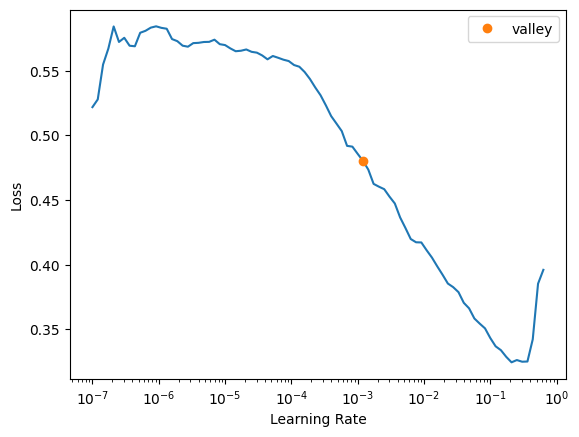

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(10, 2.089e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.207581,0.178775,0.967063,00:02
1,0.147470,0.141183,0.969492,00:02
2,0.139716,0.131351,0.970302,00:02
3,0.137429,0.128068,0.970842,00:02
4,0.133075,0.126338,0.970842,00:02
5,0.136768,0.127401,0.969222,00:02
6,0.111145,0.125542,0.970572,00:02
7,0.137619,0.123865,0.971112,00:02
8,0.131695,0.123411,0.970842,00:02
9,0.131716,0.123531,0.971112,00:02


In [19]:
dl = test_dl

In [20]:
learn.save('nn_pnality_tp_pd')

Path('models/nn_pnality_tp_pd.pth')

In [21]:
#learn.load('nn_pnality_tp_pd')  

In [22]:
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_proba = (a_preds[:, 1])

In [23]:
a_preds.shape

torch.Size([6175, 2])

In [24]:
nn_preds_y.shape,sub_df.shape

(torch.Size([6175, 2]), (6175, 2))

In [25]:
nn_preds_x

tensor([[0.9768, 0.0232],
        [0.9398, 0.0602],
        [0.9956, 0.0044],
        ...,
        [0.0901, 0.9099],
        [0.1138, 0.8862],
        [0.9919, 0.0081]])

In [26]:
nn_preds_y

tensor([[0.9919, 0.0081],
        [0.0157, 0.9843],
        [0.9581, 0.0419],
        ...,
        [0.9951, 0.0049],
        [0.9863, 0.0137],
        [0.0113, 0.9887]])

In [27]:
final_preds = torch.round(a_preds).long()
final_preds = final_preds[:,1]
final_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [28]:
final_preds.shape

torch.Size([6175])

In [29]:
mapping = dict(enumerate(dls.vocab))
mapping

{0: 'Extrovert', 1: 'Introvert'}

In [30]:
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in final_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


In [31]:
#!rm submission.csv
#sub_df['Personality'] = final_preds
#sub_df.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='Id')
#sub

## Gradient Boosting

### Random Forest

In [32]:
%%time
rf = RandomForestClassifier(1000, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))
rf_preds_x = tensor(rf_model.predict(X_test))

rf_score = accuracy_score(y_test,rf_preds_x)
rf_score

CPU times: user 9.27 s, sys: 83.6 ms, total: 9.35 s
Wall time: 9.34 s


0.9697624190064795

In [33]:
rf_preds

tensor([0, 1, 0,  ..., 0, 0, 1], dtype=torch.int8)

In [34]:
rf_oof_preds, rf_submission_preds, rf_mean_score, rf_fold_scores = cross_val_predict(
    model_class=RandomForestClassifier
)

Fold 1 AUC: 0.971323
Fold 2 AUC: 0.965924
Fold 3 AUC: 0.969298
Fold 4 AUC: 0.964238
Fold 5 AUC: 0.968286

Mean AUC: 0.967814


In [35]:
rf_oof_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [36]:
rf_submission_preds = torch.round(torch.tensor(rf_submission_preds)).long()
rf_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [37]:
 rf_mean_score

0.9678137651821862

In [38]:
rf_fold_scores

[0.9713225371120108,
 0.9659244264507423,
 0.9692982456140351,
 0.9642375168690959,
 0.9682860998650472]

In [39]:
rf_oof_preds.shape, rf_submission_preds.shape, rf_mean_score

((14820,), torch.Size([6175]), 0.9678137651821862)

#### Random forest feature importance

In [40]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=True)

In [41]:
fi = rf_feat_importance(rf_model, X_train)
#fi[:10]
fi

,cols,imp
5,Friends_circle_size_na,0.000564
4,Going_outside_na,0.000778
2,Time_spent_Alone_na,0.001065
6,Post_frequency_na,0.001109
3,Social_event_attendance_na,0.001203
10,Friends_circle_size,0.045682
9,Going_outside,0.109400
11,Post_frequency,0.122543
8,Social_event_attendance,0.123020
7,Time_spent_Alone,0.160654


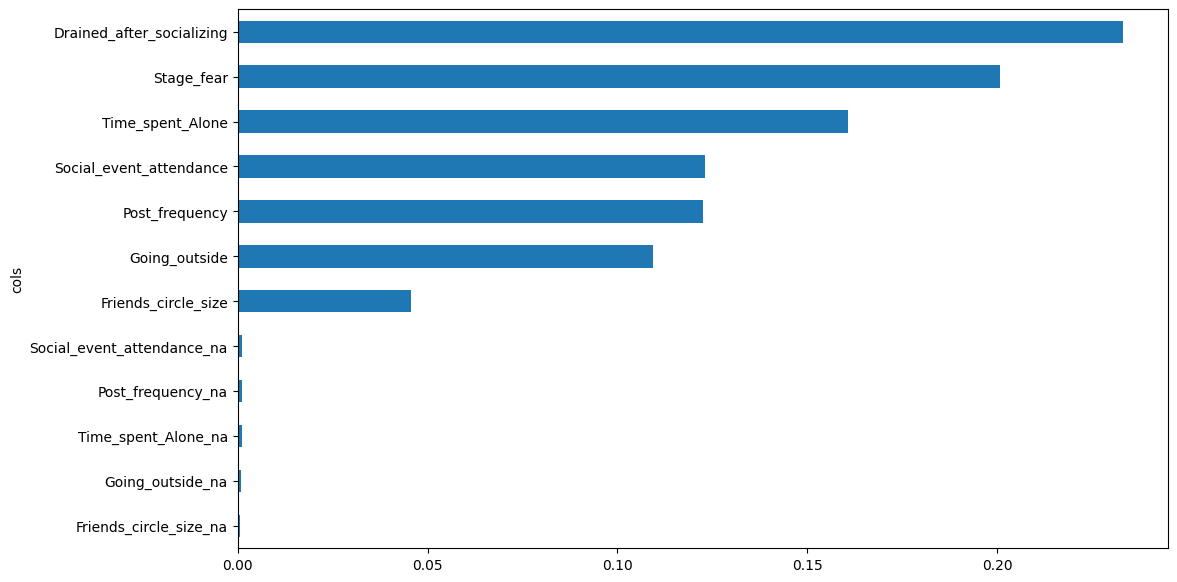

In [42]:
#feature importance visualization
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

#plot_fi(fi[:30]);
plot_fi(fi);

In [43]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in rf_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


### XGBoost

##### Single Fold¶

In [44]:
%%time
xgb_model = xgb.XGBClassifier()
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

xgb_score = accuracy_score(y_test,xgb_preds_x)
xgb_score

CPU times: user 257 ms, sys: 8.96 ms, total: 266 ms
Wall time: 160 ms


0.9681425485961123

In [45]:
xgb_oof_preds, xgb_submission_preds, xgb_mean_score, xgb_fold_scores = cross_val_predict(
    model_class=xgb.XGBClassifier
)

Fold 1 AUC: 0.967274
Fold 2 AUC: 0.967274
Fold 3 AUC: 0.970985
Fold 4 AUC: 0.963563
Fold 5 AUC: 0.968286

Mean AUC: 0.967476


In [46]:
xgb_oof_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [47]:
xgb_submission_preds = torch.round(torch.tensor(xgb_submission_preds)).long()
xgb_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [48]:
xgb_mean_score,xgb_fold_scores

(0.967476383265857,
 [0.9672739541160594,
  0.9672739541160594,
  0.9709851551956815,
  0.9635627530364372,
  0.9682860998650472])

In [49]:
xgb_oof_preds.shape, xgb_submission_preds.shape, xgb_mean_score
#fold_scores.shape

((14820,), torch.Size([6175]), 0.967476383265857)

In [50]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in xgb_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
print(sub)

      Personality
id               
18524   Extrovert
18525   Introvert
18526   Extrovert
18527   Extrovert
18528   Introvert
...           ...
24694   Extrovert
24695   Introvert
24696   Extrovert
24697   Extrovert
24698   Introvert

[6175 rows x 1 columns]


### LGBM

In [51]:
%%time
#ds subset
lgbm_model = lgb.LGBMClassifier()
lgbm_model = lgbm_model.fit(X_train, y_train)

#test set preds
#lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))
lgbm_preds = tensor(lgbm_model.predict(test_dl.xs))

lgbm_preds_x = tensor(lgbm_model.predict(X_test))

lgbm_score = accuracy_score(y_test,lgbm_preds_x)
lgbm_score

[LightGBM] [Info] Number of positive: 3861, number of negative: 10959
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 14820, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260526 -> initscore=-1.043235
[LightGBM] [Info] Start training from score -1.043235
CPU times: user 333 ms, sys: 17.3 ms, total: 350 ms
Wall time: 220 ms


0.968682505399568

In [52]:
lgbm_oof_preds, lgbm_submission_preds, lgbm_mean_score, lgbm_fold_scores = cross_val_predict(
    model_class=lgb.LGBMClassifier
)

[LightGBM] [Info] Number of positive: 3089, number of negative: 8767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260543 -> initscore=-1.043147
[LightGBM] [Info] Start training from score -1.043147
Fold 1 AUC: 0.969636
[LightGBM] [Info] Number of positive: 3089, number of negative: 8767
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 11856, number of used features: 12
[Ligh

In [53]:
lgbm_oof_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [54]:
lgbm_submission_preds = torch.round(torch.tensor(lgbm_submission_preds)).long()
lgbm_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [55]:
lgbm_mean_score,lgbm_fold_scores

(0.9678812415654521,
 [0.9696356275303644,
  0.9665991902834008,
  0.9709851551956815,
  0.9635627530364372,
  0.9686234817813765])

In [56]:
lgbm_oof_preds.shape, lgbm_submission_preds.shape, lgbm_mean_score

((14820,), torch.Size([6175]), 0.9678812415654521)

In [57]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
lgb_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    lgb_model_fold = lgb.LGBMClassifier()
    lgb_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = lgb_model_fold.predict(X_fold_val)
    y_pred_fold_tt = lgb_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    lgb_cv_score = accuracy_score(y_fold_val, lgb_model_fold.predict(X_fold_val))
    lgb_fold_scores.append(lgb_cv_score)
    
    print(f"Fold {fold} AUC: {lgb_cv_score}")

lgb_mean_score = np.mean(lgb_fold_scores)
print(f"Mean AUC: {lgb_mean_score}")

[LightGBM] [Info] Number of positive: 3475, number of negative: 9863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 13338, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260534 -> initscore=-1.043196
[LightGBM] [Info] Start training from score -1.043196
Fold 1 AUC: 0.975033738191633
[LightGBM] [Info] Number of positive: 3475, number of negative: 9863
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 13338, number of used features:

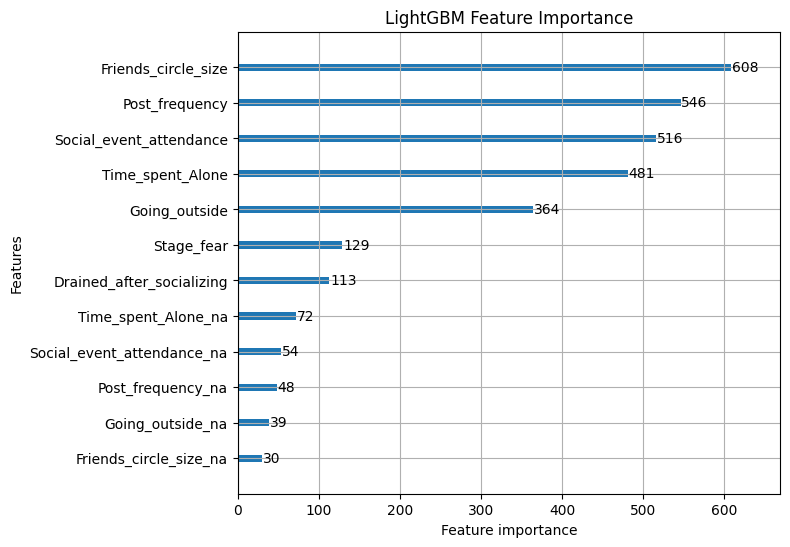

In [58]:
# Plot feature importance without using Gain or split
lgb.plot_importance(lgbm_model, figsize=(7,6), title="LightGBM Feature Importance")
#plt.title('LGBM Feature Importance')
#plt.tight_layout()
plt.show()

In [59]:
!rm submission.csv
mapping = dict(enumerate(dls.vocab))
submit = pd.read_csv(path/'sample_submission.csv')
submit['Personality'] = [mapping[pred.item()] for pred in lgbm_preds]
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv', index_col='id')
#print(sub)

### CatBoost

In [60]:
%%time
#using full ds
cat_model_params = CatBoostClassifier()
cat_model_params = cat_model_params.fit(X_train, y_train, verbose=False)


cat_preds_params = tensor(cat_model_params.predict(test_dl.xs))

cat_preds_x_params = tensor(cat_model_params.predict(X_test))

cat_score_params = accuracy_score(y_test,cat_preds_x_params)
cat_score_params

CPU times: user 13.7 s, sys: 2.71 s, total: 16.4 s
Wall time: 4.27 s


0.9684125269978402

In [61]:
%%time
#using full ds
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(X_train, y_train, verbose=False)


cat_preds = tensor(cat_model.predict(test_dl.xs))

cat_preds_x = tensor(cat_model.predict(X_test))

cat_score = accuracy_score(y_test,cat_preds_x)
cat_score

CPU times: user 13.9 s, sys: 2.66 s, total: 16.5 s
Wall time: 4.22 s


0.9684125269978402

In [62]:
cat_oof_preds_y, cat_submission_preds_y, cat_mean_score_y, cat_fold_scores_y = cross_val_predict(
    model_class=CatBoostClassifier,
    
)

Learning rate set to 0.029615
0:	learn: 0.6454579	total: 4.55ms	remaining: 4.54s
1:	learn: 0.6023899	total: 7.76ms	remaining: 3.87s
2:	learn: 0.5628842	total: 11.7ms	remaining: 3.89s
3:	learn: 0.5262396	total: 15.3ms	remaining: 3.82s
4:	learn: 0.4930232	total: 19ms	remaining: 3.78s
5:	learn: 0.4637172	total: 22.5ms	remaining: 3.72s
6:	learn: 0.4360015	total: 25.8ms	remaining: 3.67s
7:	learn: 0.4110941	total: 29.1ms	remaining: 3.61s
8:	learn: 0.3880968	total: 32.7ms	remaining: 3.6s
9:	learn: 0.3674800	total: 35.9ms	remaining: 3.55s
10:	learn: 0.3482149	total: 39.2ms	remaining: 3.53s
11:	learn: 0.3308391	total: 42.6ms	remaining: 3.51s
12:	learn: 0.3148828	total: 46.3ms	remaining: 3.51s
13:	learn: 0.3001409	total: 49.9ms	remaining: 3.51s
14:	learn: 0.2874387	total: 52.6ms	remaining: 3.45s
15:	learn: 0.2755117	total: 56.1ms	remaining: 3.45s
16:	learn: 0.2640467	total: 59.5ms	remaining: 3.44s
17:	learn: 0.2547317	total: 62.1ms	remaining: 3.39s
18:	learn: 0.2453884	total: 65.8ms	remaining: 3

In [63]:
cat_score_params,cat_score

(0.9684125269978402, 0.9684125269978402)

In [64]:
cat_oof_preds, cat_submission_preds, cat_mean_score, cat_fold_scores = cross_val_predict(
    model_class=CatBoostClassifier
)

Learning rate set to 0.029615
0:	learn: 0.6454579	total: 4.42ms	remaining: 4.42s
1:	learn: 0.6023899	total: 7.84ms	remaining: 3.91s
2:	learn: 0.5628842	total: 11.6ms	remaining: 3.85s
3:	learn: 0.5262396	total: 15.4ms	remaining: 3.83s
4:	learn: 0.4930232	total: 19.1ms	remaining: 3.81s
5:	learn: 0.4637172	total: 22.9ms	remaining: 3.79s
6:	learn: 0.4360015	total: 26.6ms	remaining: 3.77s
7:	learn: 0.4110941	total: 30.1ms	remaining: 3.73s
8:	learn: 0.3880968	total: 33.8ms	remaining: 3.73s
9:	learn: 0.3674800	total: 37.5ms	remaining: 3.71s
10:	learn: 0.3482149	total: 41.4ms	remaining: 3.72s
11:	learn: 0.3308391	total: 45.3ms	remaining: 3.73s
12:	learn: 0.3148828	total: 49.2ms	remaining: 3.73s
13:	learn: 0.3001409	total: 53.1ms	remaining: 3.74s
14:	learn: 0.2874387	total: 56.1ms	remaining: 3.69s
15:	learn: 0.2755117	total: 59.8ms	remaining: 3.68s
16:	learn: 0.2640467	total: 63.7ms	remaining: 3.68s
17:	learn: 0.2547317	total: 66.6ms	remaining: 3.63s
18:	learn: 0.2453884	total: 70.5ms	remaining

In [65]:
cat_oof_preds

array([0., 1., 0., ..., 0., 0., 0.])

In [66]:
cat_submission_preds = torch.round(torch.tensor(cat_submission_preds)).long()
cat_submission_preds

tensor([0, 1, 0,  ..., 0, 0, 1])

In [67]:
cat_mean_score,cat_mean_score_y

(0.968353576248313, 0.968353576248313)

In [68]:
cat_mean_score,cat_mean_score_y

(0.968353576248313, 0.968353576248313)

In [69]:
cat_oof_preds.shape, cat_submission_preds.shape, cat_mean_score

((14820,), torch.Size([6175]), 0.968353576248313)

In [70]:
%%time
K_FOLDS = 10
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
cat_fold_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train), 1):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    
    cat_model_fold = CatBoostClassifier()
    cat_model_fold.fit(X_fold_train, y_fold_train)
    
    # Predict on validation set
    y_pred_fold = cat_model_fold.predict(X_fold_val)
    y_pred_fold_tt = cat_model_fold.predict(test_dl.xs)
    
    # Calculate accuracy score
    cat_cv_score = accuracy_score(y_fold_val, cat_model_fold.predict(X_fold_val))
    cat_fold_scores.append(cat_cv_score)
    
    print(f"Fold {fold} AUC: {cat_cv_score}")

catboost_mean_score = np.mean(cat_fold_scores)
print(f"Mean AUC: {catboost_mean_score}")

Learning rate set to 0.031142
0:	learn: 0.6436146	total: 4.64ms	remaining: 4.63s
1:	learn: 0.5978163	total: 8.23ms	remaining: 4.11s
2:	learn: 0.5569067	total: 12ms	remaining: 4s
3:	learn: 0.5188704	total: 15.6ms	remaining: 3.89s
4:	learn: 0.4848311	total: 18.7ms	remaining: 3.72s
5:	learn: 0.4538436	total: 22.5ms	remaining: 3.73s
6:	learn: 0.4260431	total: 26.1ms	remaining: 3.71s
7:	learn: 0.3997905	total: 29.7ms	remaining: 3.68s
8:	learn: 0.3767983	total: 33.4ms	remaining: 3.68s
9:	learn: 0.3558297	total: 37.3ms	remaining: 3.69s
10:	learn: 0.3368240	total: 40.5ms	remaining: 3.64s
11:	learn: 0.3194215	total: 44.1ms	remaining: 3.63s
12:	learn: 0.3040124	total: 47.6ms	remaining: 3.62s
13:	learn: 0.2897415	total: 51.4ms	remaining: 3.62s
14:	learn: 0.2774719	total: 54ms	remaining: 3.55s
15:	learn: 0.2659821	total: 57.5ms	remaining: 3.54s
16:	learn: 0.2549104	total: 61.4ms	remaining: 3.55s
17:	learn: 0.2450785	total: 65.1ms	remaining: 3.55s
18:	learn: 0.2359457	total: 68.9ms	remaining: 3.56s

In [71]:
feature_importance = cat_model.get_feature_importance()
feature_names = train_df.columns

# Display feature importance
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance:.2f}")

Feature: Time_spent_Alone, Importance: 9.18
Feature: Stage_fear, Importance: 8.59
Feature: Social_event_attendance, Importance: 1.83
Feature: Going_outside, Importance: 1.76
Feature: Drained_after_socializing, Importance: 1.40
Feature: Friends_circle_size, Importance: 0.62
Feature: Post_frequency, Importance: 1.19
Feature: Personality, Importance: 15.39


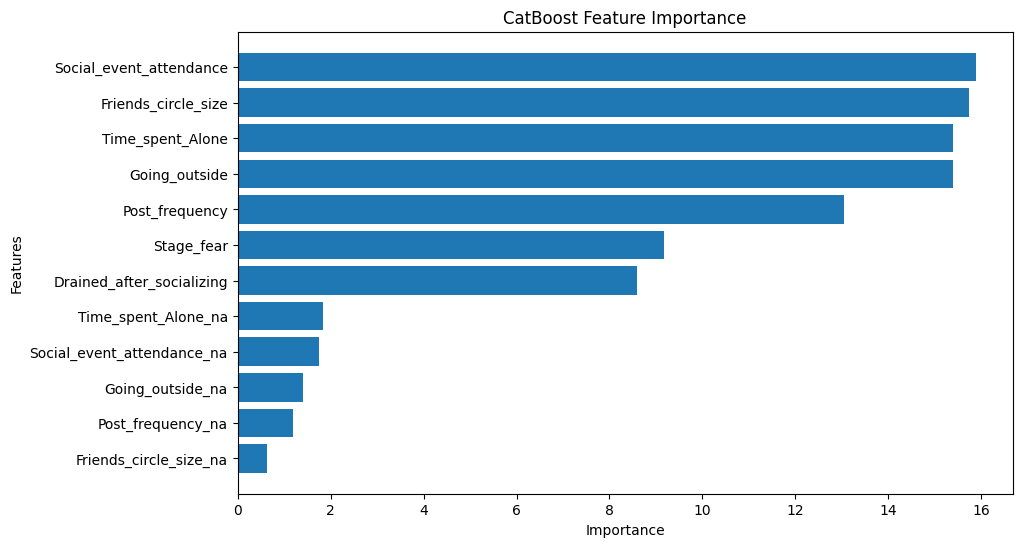

In [72]:
#importances = cat_model.get_feature_importance(type='PredictionValuesChange')
importances = cat_model.get_feature_importance()
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In [73]:
#!rm submission.csv
#mapping = dict(enumerate(dls.vocab))
#submit = pd.read_csv(path/'sample_submission.csv')
#submit['Personality'] = [mapping[pred.item()] for pred in cat_preds]
#submit.to_csv('submission.csv', index=False)
#sub = pd.read_csv('submission.csv', index_col='id')
#print(sub)

## Ranking

In [74]:
accuracy = pd.DataFrame({
    'algorithm': ['Random Forest',
                  'RF CV','XGBoost','XGBoost CV','LGBM','LGBM CV','CatBoost','CatBoost CV',
                 ],
    'accuracy': [rf_mean_score,rf_score,xgb_score,xgb_mean_score,lgbm_score,
                 lgbm_mean_score,cat_score,cat_mean_score,
           ]
})

accuracy_sorted = accuracy.sort_values(by='accuracy', ascending=False)
accuracy_sorted

,algorithm,accuracy
1,RF CV,0.969762
4,LGBM,0.968683
6,CatBoost,0.968413
7,CatBoost CV,0.968354
2,XGBoost,0.968143
5,LGBM CV,0.967881
0,Random Forest,0.967814
3,XGBoost CV,0.967476
